In [1]:
import sys, os

module_path = os.path.abspath(os.path.join(".."))

if module_path not in sys.path:
    sys.path.append(module_path)

# move directory
os.chdir("..")

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat

# Load result
with open("./dataset/two-stream/ppo-control.mat", "rb") as file:
    mdat = loadmat(file)

In [3]:
snapshot = mdat["snapshot"]
E = mdat["E"]
PE = mdat["PE"]

N = mdat["N"].item()
Nt = snapshot.shape[1]
N_mesh = mdat["N_mesh"].item()
L = mdat["L"].item()
dx = L / N_mesh
tmin = mdat["tmin"][0]
tmax = mdat["tmax"][0]
dt = mdat["dt"][0].item()
ts = np.linspace(tmin, tmax, Nt)

coeff_cos = mdat['coeff_cos']
coeff_sin = mdat["coeff_sin"]

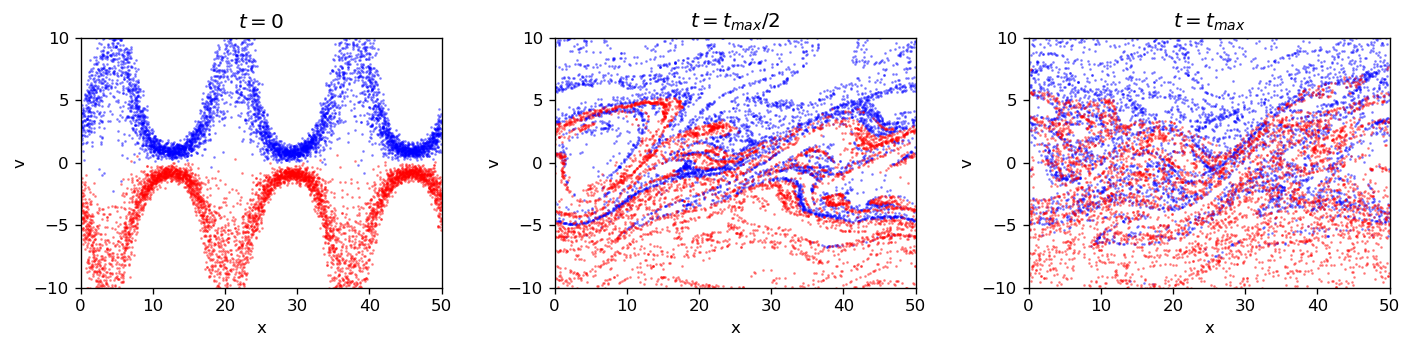

In [4]:
from src.plot import plot_two_stream_evolution

fig, axes = plot_two_stream_evolution(snapshot, None, None, 0, L, -10.0, 10.0)

/home/jk9075/codes/Optimal-control-1D-Electrostatic-Plasma/src/plot.py:590: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc="upper right")


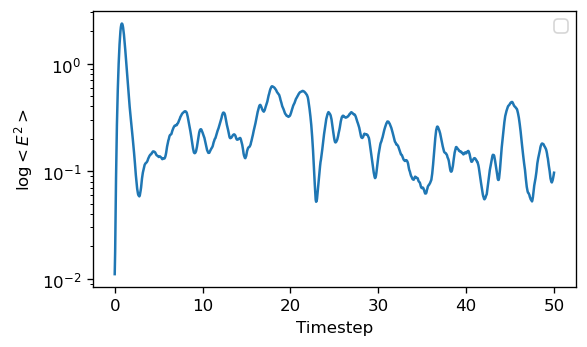

In [6]:
from src.plot import plot_log_E

fig, ax = plot_log_E(tmax, L, dx, N_mesh, snapshot, None, None)

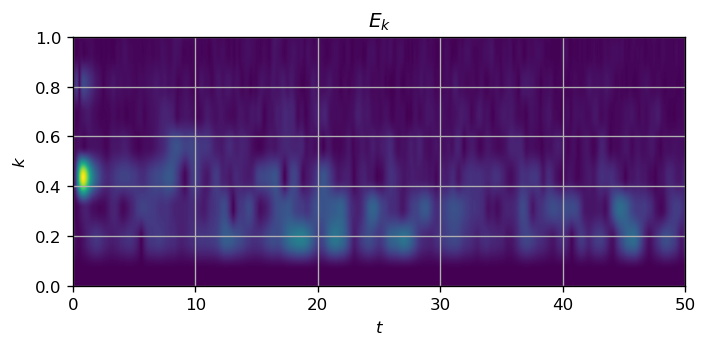

In [5]:
from src.plot import plot_E_k_spectrum

fig, ax = plot_E_k_spectrum(tmax, L, dx, N_mesh, snapshot, None, None)